# 第5回講義 宿題

## 課題

今Lessonで学んだことに工夫を加えて，CNNでより高精度なCIFAR10の分類器を実装してみましょう．精度上位者はリーダーボードに載ります．

### 目標値

Accuracy 78%

### ルール

- 訓練データはx_train， t_train，テストデータはx_testで与えられます．
- 予測ラベルは one_hot表現ではなく0~9のクラスラベル で表してください．
- **下のセルで指定されているx_train，t_train以外の学習データは使わないでください．**
- 今回から基本的にAPI制限はありません．
- ただしCNNベースでないモデル（Vision Transformerなど）やtorchvision等の既存モデル，学習済みモデルは用いないでください．

### 提出方法

- 2つのファイルを提出していただきます．
  - テストデータ (x_test) に対する予測ラベルをcsvファイル (ファイル名: submission_pred.csv) で提出してください．
  - それに対応するpythonのコードをsubmission_code.pyとして提出してください (%%writefileコマンドなどを利用してください)．

### 評価方法

- 予測ラベルのt_testに対する精度 (Accuracy) で評価します．
- 提出後即時採点を行い，Leader Boardが更新されます．
- 締切後の点数を最終的な評価とします．

### データの読み込み

- この部分は修正しないでください

In [1]:
import random
import os

import numpy as np
import pandas as pd
import torch
from torchvision import transforms
from tqdm import tqdm_notebook as tqdm
from PIL import Image
from sklearn.model_selection import train_test_split

# 学習データ
data_dir = "../data"
x_train = np.load(os.path.join(data_dir, "x_train.npy"))
y_train = np.load(os.path.join(data_dir, "t_train.npy"))


# テストデータ
x_test = np.load(os.path.join(data_dir, "x_test.npy"))

class train_dataset(torch.utils.data.Dataset):
    def __init__(self, x_train, y_train):
        data = x_train.astype('float32')
        self.x_train = []
        for i in range(data.shape[0]):
            self.x_train.append(Image.fromarray(np.uint8(data[i])))
        self.y_train = y_train
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.x_train)

    def __getitem__(self, idx):
        return self.transform(self.x_train[idx]), torch.tensor(y_train[idx], dtype=torch.long)

class test_dataset(torch.utils.data.Dataset):
    def __init__(self, x_test):
        data = x_test.astype('float32')
        self.x_test = []
        for i in range(data.shape[0]):
            self.x_test.append(Image.fromarray(np.uint8(data[i])))
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.x_test)

    def __getitem__(self, idx):
        return self.transform(self.x_test[idx])

trainval_data = train_dataset(x_train, y_train)
test_data = test_dataset(x_test)

/Users/keisuketoyoda/utokyo/graduate/deep_learning/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/keisuketoyoda/utokyo/graduate/deep_learning/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
x_train.shape, y_train.shape, x_test.shape

((50000, 32, 32, 3), (50000,), (10000, 32, 32, 3))

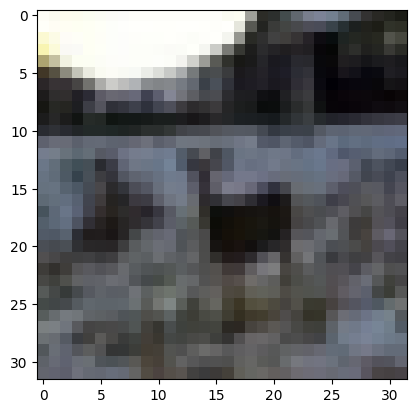

In [26]:
import matplotlib.pyplot as plt
import torchvision

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

data_iter = iter(trainval_data)
images, labels = next(data_iter)

imshow(torchvision.utils.make_grid(images))

### 畳み込みニューラルネットワーク(CNN)の実装

In [ ]:
def fix_seed(seed=1234):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


fix_seed(seed=42)


class gcn():
    # gcn: Global Contrast Normalization
    def __init__(self):
        pass

    def __call__(self, x):
        mean = torch.mean(x)
        std = torch.std(x)
        return (x - mean)/(std + 10**(-6))  # 0除算を防ぐ


class ZCAWhitening():
    def __init__(self, epsilon=1e-4, device="mps"):  # 計算が重いのでGPUを用いる
        self.epsilon = epsilon
        self.device = device

    def fit(self, images):  # 変換行列と平均をデータから計算
        x = images[0][0].reshape(1, -1)
        self.mean = torch.zeros([1, x.size()[1]]).to(self.device)
        con_matrix = torch.zeros([x.size()[1], x.size()[1]]).to(self.device)
        for i in range(len(images)):  # 各データについての平均を取る
            x = images[i][0].reshape(1, -1).to(self.device)
            self.mean += x / len(images)
            con_matrix += torch.mm(x.t(), x) / len(images)
            if i % 10000 == 0:
                print("{0}/{1}".format(i, len(images)))
        self.E, self.V = torch.linalg.eigh(con_matrix)  # 固有値分解
        self.E = torch.max(self.E, torch.zeros_like(self.E)) # 誤差の影響で負になるのを防ぐ
        self.ZCA_matrix = torch.mm(torch.mm(self.V, torch.diag((self.E.squeeze()+self.epsilon)**(-0.5))), self.V.t())
        print("completed!")

    def __call__(self, x):
        size = x.size()
        x = x.reshape(1, -1).to(self.device)
        x -= self.mean
        x = torch.mm(x, self.ZCA_matrix.t())
        x = x.reshape(tuple(size))
        x = x.to("cpu")
        return x


# (datasetのクラスを自作したので，このあたりの処理が少し変わっています)

zca = ZCAWhitening()
zca.fit(trainval_data)

val_size = 3000
train_data, val_data = torch.utils.data.random_split(trainval_data, [len(trainval_data)-val_size, val_size])  # 訓練データと検証データに分割


# 前処理を定義
transform_train = transforms.Compose([transforms.ToTensor(), gcn(), zca])

transform = 

# データセットに前処理を設定
trainval_data.transform = transform_train
test_data.transform = transform

batch_size = 64

dataloader_train = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=True
)

dataloader_test = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False
)


In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F

rng = np.random.RandomState(1234)
random_state = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


conv_net = # WRITE ME


def init_weights(m):  # Heの初期化
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.0)


conv_net.apply(init_weights)


n_epochs = 5
lr = 0.01
device = 'cuda'

conv_net.to(device)
optimizer = # WRITE ME
loss_function = # WRITE ME

In [ ]:
for epoch in range(n_epochs):
    losses_train = []
    losses_valid = []

    conv_net.train()
    n_train = 0
    acc_train = 0
    for x, t in dataloader_train:
        # WRITE ME

        acc_train += (pred == t).float().sum().item()
        losses_train.append(loss.tolist())

    conv_net.eval()
    n_val = 0
    acc_val = 0
    for x, t in dataloader_valid:
        # WRITE ME

        acc_val += (pred == t).float().sum().item()
        losses_valid.append(loss.tolist())

    print('EPOCH: {}, Train [Loss: {:.3f}, Accuracy: {:.3f}], Valid [Loss: {:.3f}, Accuracy: {:.3f}]'.format(
        epoch,
        np.mean(losses_train),
        acc_train/n_train,
        np.mean(losses_valid),
        acc_val/n_val
    ))

In [ ]:
conv_net.eval()

t_pred = []
for x in dataloader_test:

    x = x.to(device)

    # 順伝播
    y = conv_net.forward(x)

    # モデルの出力を予測値のスカラーに変換
    pred = y.argmax(1).tolist()

    t_pred.extend(pred)

submission = pd.Series(t_pred, name='label')
submission.to_csv('drive/MyDrive/Colab Notebooks/DLBasics2023_colab/Lecture05/submission_pred.csv', header=True, index_label='id')